# XAI Tutorial of Gianni Franchi Rémi KAZMIERCZAK
**PLEASE write your name and first name here:** Zait Nawel

Welcome to your XAI project!
**In this notebook, you will**:
- Learn  about classification
- Learn about XAI
- Learn about CLIP
- Learn what are Concept Bottleneck Models (CBMs)


If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

## 0 Visualisation of the dataset


In [ ]:
# First we download the dataset. In order to have fast download please use this command line
!pip install gdown

!gdown 1PdMjITeGZjfSp__87mfpY8mTcMTPsDB0
!unzip Cats_Dogs_Cars_Reduced.zip

We have constructed a dataset that includes images of black and white dogs, cars, and cats. The dataset consists of three classes: **cats**, **dogs**, and **cars**. To have a better understanding of the DNN biais, we've organized explicit folders for each color within each class. This arrangement allows us to explore whether the Deep Neural Network (DNN) relies solely on color information for classification, enabling us to train and evaluate the model with images of a single multiple colors.

In [2]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F



class Cats_Dogs_dataset_x(torch.utils.data.Dataset):
  # Cats_Dogs_dataset (torch dataset)

  def __init__(self,root,phase,preprocess,device='cuda',set_dogs='Black+White',set_cats='Black+White',
               set_cars='Black+White'):
    super(Cats_Dogs_dataset_x, self).__init__()

    '''
    Cats and dogs dataset + some tools to create usefuls subdatasets
    root: Root of the data (/.../semanticPascalPart)
    phase: Phase of the learning in ['train','val','test']
    shuffle: Shuffle the dataset items
    device: Gpu (or cpu) to use
    save_mode: after precomputing the images, save this as npy files
    '''

    self.preprocess = preprocess
    self.device = device
    self.List_classes = ['Dogs','Cats','Cars']
    self.info_dataset = {'Dogs':set_dogs.split('+'),'Cats':set_cats.split('+'),'Cars':set_cars.split('+')}
    self.img_paths = []
    self.labels = []

    # New version save npy files

    for pet_class in ['Dogs','Cats','Cars']:
      for color in self.info_dataset[pet_class] :
        paths_images_subset = sorted(glob.glob(root+'/'+pet_class+'/'+color+'/*.jpg'))
        imgs_train_subset,imgs_val_subset,imgs_test_subset = self.split_dataset(paths_images_subset)
        if phase == 'train':
          self.img_paths+=imgs_train_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_train_subset))]

        if phase == 'test':
          self.img_paths+=imgs_val_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_val_subset))]

        if phase == 'val':
          self.img_paths+=imgs_test_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_test_subset))]

  def split_dataset(self,img_ids,split_seed=-1):

    if split_seed != -1 :

      np.random.seed(split_seed)
      np.random.shuffle(img_ids)

    l = len(img_ids)

    img_ids_train = img_ids[:int(l * 0.6)]
    img_ids_test = img_ids[int(l * 0.6):int(l * 0.8)]
    img_ids_val = img_ids[int(l * 0.8):]

    return img_ids_train, img_ids_val, img_ids_test

    return label_to_return

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):

    path = self.img_paths[index]
    img = Image.open(path)

    img_tensor= self.preprocess(img)
    img_tensor = img_tensor.to(self.device)

    label = self.labels[index]

    return {'input':img_tensor,'label':label,'path':path}

In [3]:
all_color = True
color_white=False #  please play with the color to build biais or not
if all_color:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cats = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cars = {'train':'Black+White','val':'Black+White','test':'Black+White'}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
elif color_white:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
  D_set_cats = {'train':'White','val':'White','test':'Black+White'}
  D_set_cars = {'train':'White','val':'White','test':'Black+White'}
  #D_set_cars = {'train':'','val':'','test':''}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

## 1 Classical Supervised Classification with Resnet 50

You work now with Resnet 50, but when we work with CLIP you will work with ViT
**question 0 :  Why we do not use here ViT?**

We use ResNet50 instead of ViT (Vision Transformer) for the classical supervised classification part because CAM (Class Activation Mapping) relies on the spatial structure of convolutional feature maps. In a CNN like ResNet50, the last convolutional layer produces a spatially meaningful feature map (e.g., 7×7×2048) where each spatial position corresponds to a region of the input image. CAM works by weighting these spatial feature maps by the classification layer's weights to produce a heatmap.
ViT, on the other hand, processes the image as a sequence of patch tokens through self-attention. While attention maps exist, the standard CAM technique doesn't directly apply to ViT's architecture. Later in the lab when we use CLIP (which uses ViT), we'll use different interpretability approaches. So ResNet50 is chosen here specifically because it's compatible with CAM/GradCAM.

In [4]:
# Define the model and the optimizer

class resnet50_classif(nn.Module):
	def __init__(self,device, output_dim,Freeze_backbone=True):
		super().__init__()
		self.Freeze_backbone = Freeze_backbone
		resnet50_all = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
		self.resnet50 = torch.nn.Sequential(*(list(resnet50_all.children())[:-1]))
		self.linear = nn.Linear(2048, output_dim)

	def forward(self, x):
		if self.Freeze_backbone :
			with torch.no_grad() :
				x = self.resnet50(x)
		else :
			x = self.resnet50(x)
		x = x.squeeze(-1).squeeze(-1) # ??? Don't know why self.resnet50 return (1,2048,1,1) shape
		x = self.linear(x)
		x = F.softmax(x)

		return x


In [5]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']

model = resnet50_classif(device,len(List_classes),Freeze_backbone=False)
model.to(device)

'''import torchvision.models as models
# Define your ResNet50 model
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3).to(device)'''

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

best_score = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    if val_acc > best_score :
      best_epoch = epoch
      best_score = val_acc
      torch.save(model,'best_model_run_resnet50.pth')

# Test the trained model
best_model = torch.load('./best_model_run_resnet50.pth',weights_only=False).to(device)
test_loss, test_acc = evaluate_model(best_model, dataloader_test, criterion,device)
print('Best Epoch',best_epoch)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipython-input-2349038308.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Epoch [1/10] - Train Loss: 0.7660 - Train Acc: 90.21% - Val Loss: 0.5703 - Val Acc: 98.62%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


Epoch [2/10] - Train Loss: 0.5611 - Train Acc: 99.59% - Val Loss: 0.5722 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch [3/10] - Train Loss: 0.5585 - Train Acc: 99.49% - Val Loss: 0.5680 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Epoch [4/10] - Train Loss: 0.5546 - Train Acc: 99.85% - Val Loss: 0.5739 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch [5/10] - Train Loss: 0.5542 - Train Acc: 99.85% - Val Loss: 0.5714 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Epoch [6/10] - Train Loss: 0.5527 - Train Acc: 100.00% - Val Loss: 0.5686 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Epoch [7/10] - Train Loss: 0.5535 - Train Acc: 99.90% - Val Loss: 0.5683 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch [8/10] - Train Loss: 0.5536 - Train Acc: 99.90% - Val Loss: 0.5695 - Val Acc: 98.00%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Epoch [9/10] - Train Loss: 0.5529 - Train Acc: 99.90% - Val Loss: 0.5757 - Val Acc: 97.38%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch [10/10] - Train Loss: 0.5521 - Train Acc: 100.00% - Val Loss: 0.5694 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

Best Epoch 0
Test Loss: 0.5661 - Test Acc: 98.78%


**Question 1: Try applying [Class Activation Maps](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (CAMs) to enhance the interpretability of the classification results. (if you prefere you can use GradCam)**

**Question 2: What do you think about the quality of the explanation of your classification.** (hint show cases where the CAM is not good enough)

answer q1

/tmp/ipython-input-2349038308.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


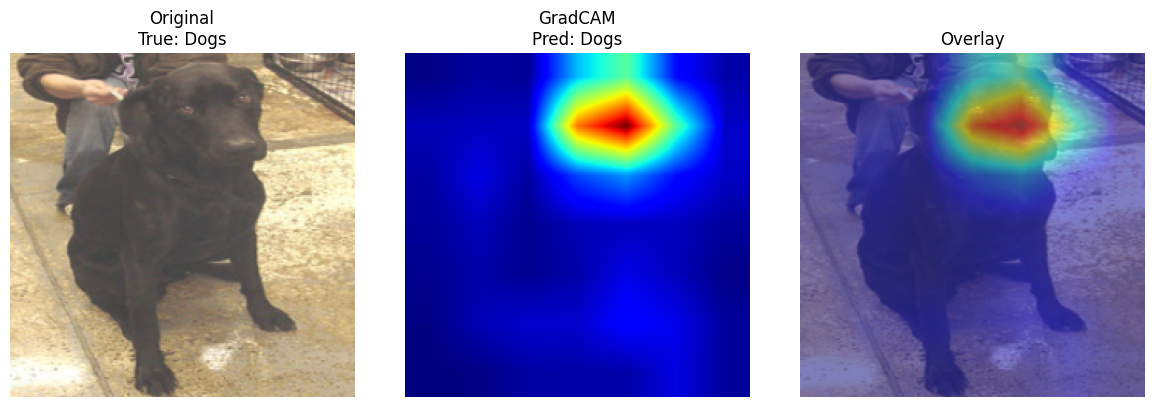

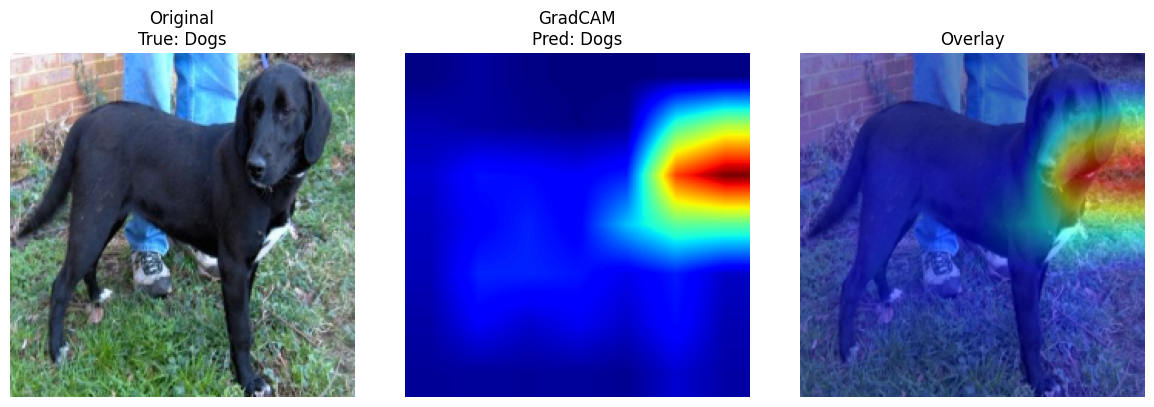

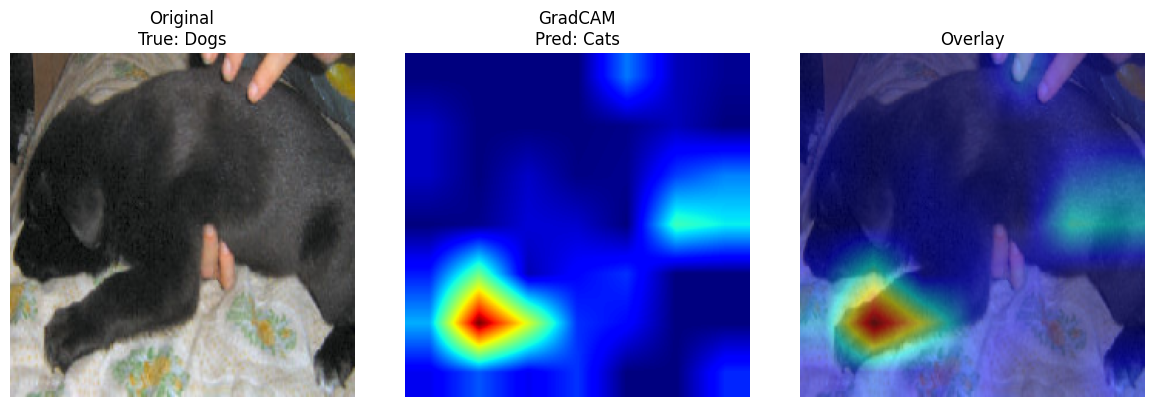

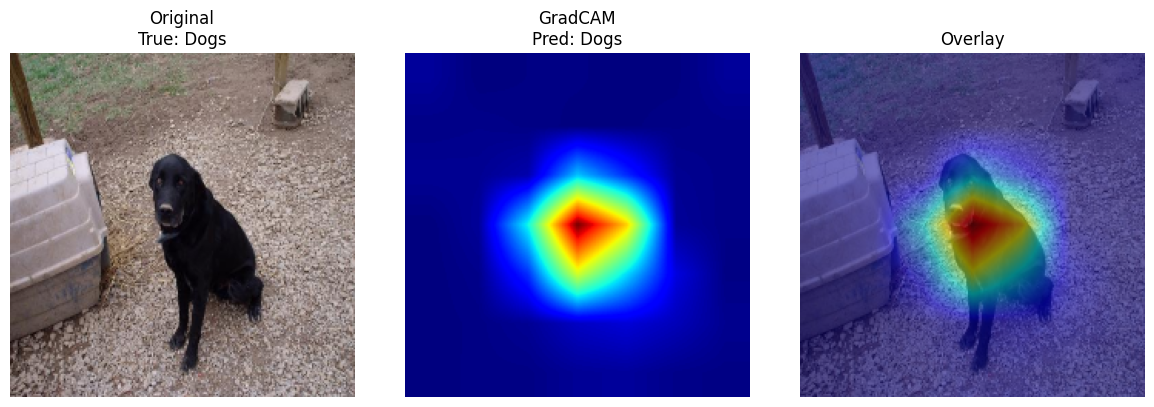

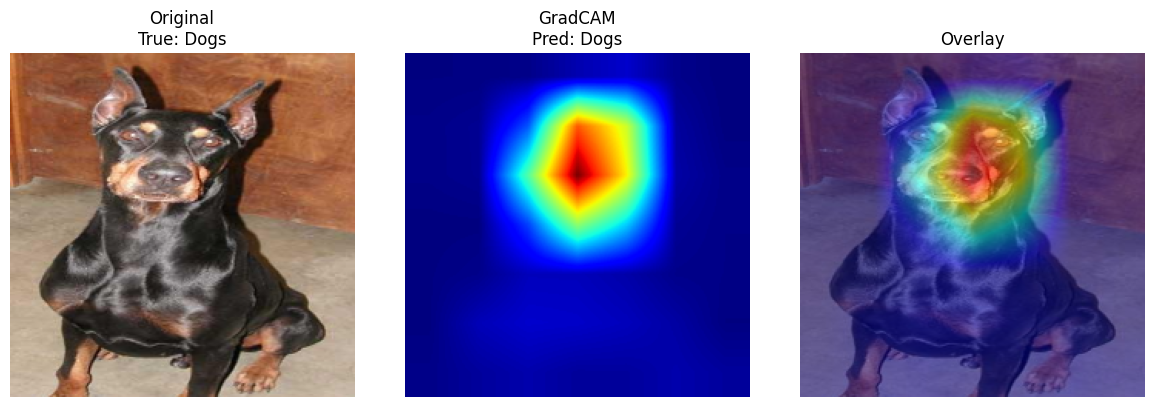

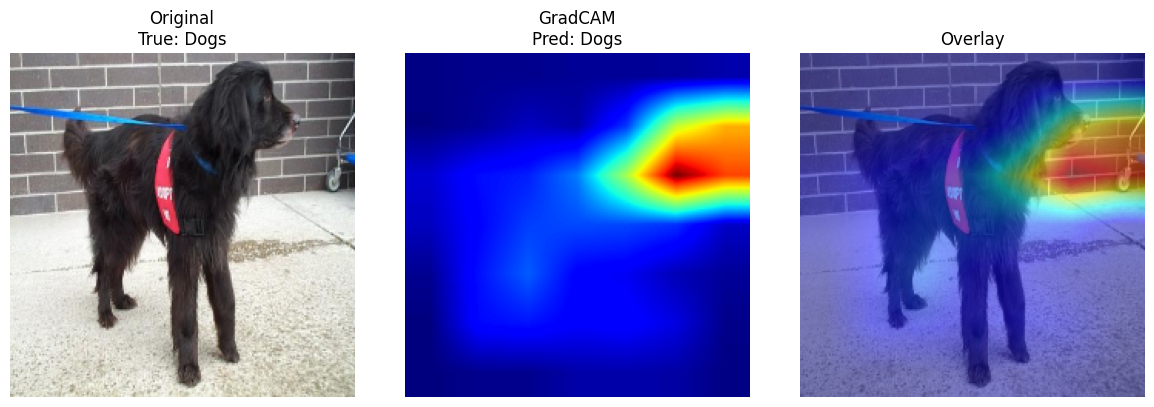

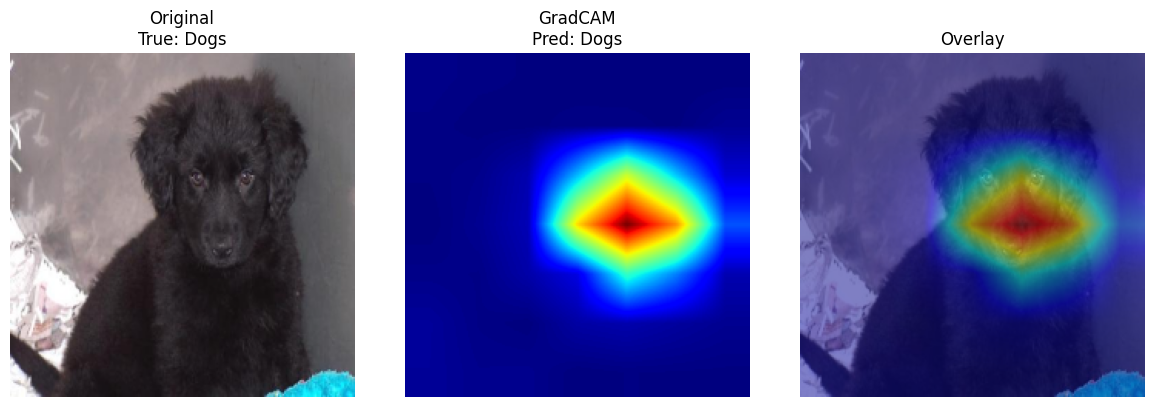

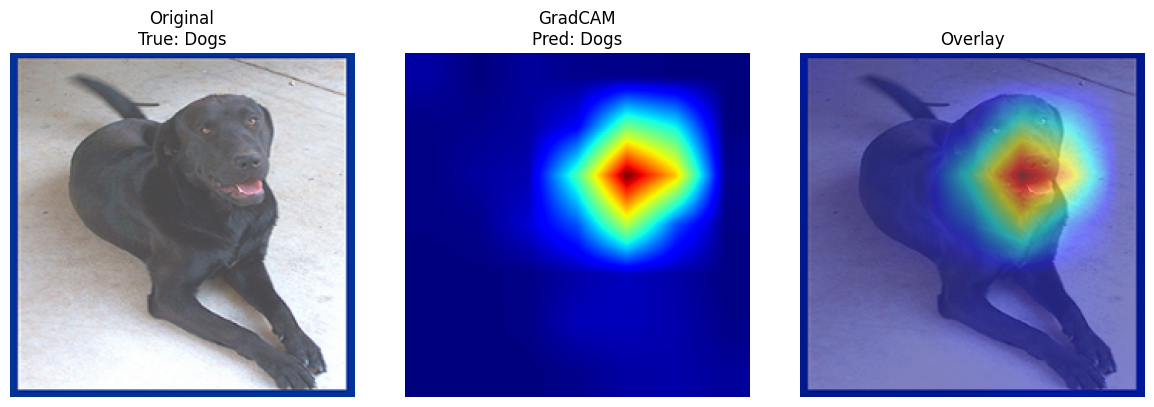

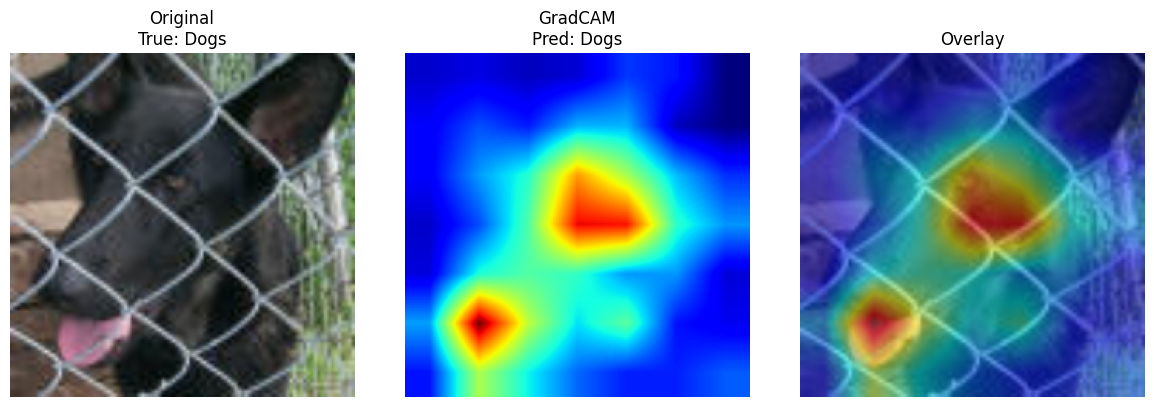

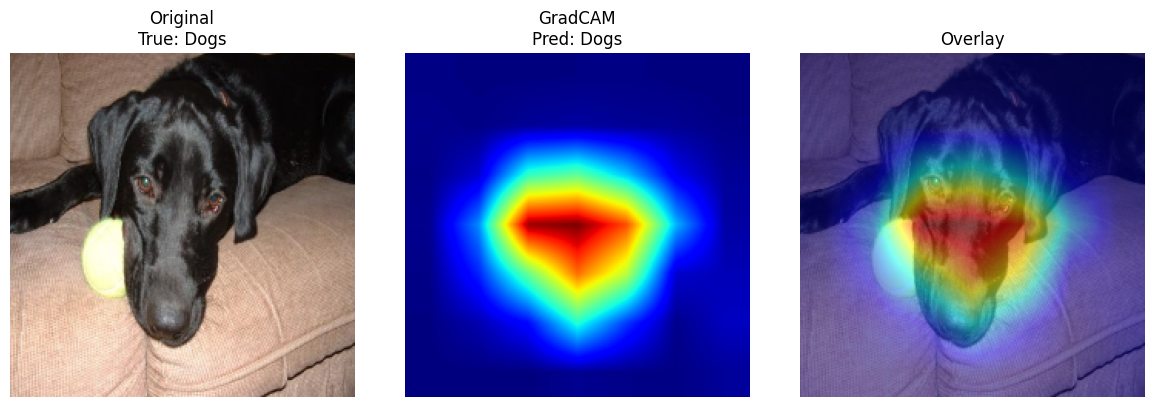

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F

# --- GradCAM Implementation ---

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.features = None
        self.gradients = None

        # Hook the last conv layer of resnet50 (layer4)
        # model.resnet50 is a Sequential; layer4 is the 8th child (index 7)
        target_layer = list(self.model.resnet50.children())[7]  # layer4
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.features = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1.0
        output.backward(gradient=one_hot, retain_graph=True)

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  # (1, C, 1, 1)
        cam = (weights * self.features).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        # Normalize
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        return cam, target_class


def show_gradcam(img_path, cam, predicted_class, true_class, List_classes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.float32(heatmap) / 255 * 0.5 + np.float32(img_resized) / 255 * 0.5
    overlay = np.clip(overlay, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img_resized)
    axes[0].set_title(f"Original\nTrue: {List_classes[true_class]}")
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title(f"GradCAM\nPred: {List_classes[predicted_class]}")
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# --- Apply GradCAM on test samples ---

best_model = torch.load('./best_model_run_resnet50.pth', weights_only=False).to(device)
# IMPORTANT: disable Freeze_backbone so gradients flow through the backbone
best_model.Freeze_backbone = False
best_model.eval()

gradcam = GradCAM(best_model)

List_classes = ['Dogs', 'Cats', 'Cars']

# Show GradCAM for a few test images
num_examples = 10
for i in range(num_examples):
    sample = Cats_Dogs_dataset_x_test[i]
    input_tensor = sample['input'].unsqueeze(0).to(device)
    true_label = sample['label']
    img_path = sample['path']

    input_tensor.requires_grad_(True)
    cam, pred_class = gradcam.generate(input_tensor)

    show_gradcam(img_path, cam, pred_class, true_label, List_classes)

answer qst 2

the GradCAM visualizations across our test samples reveal a highly inconsistent quality of explanations, which exposes fundamental limitations of this interpretability method.
Cases where GradCAM provides meaningful explanations: For a few images, the heatmap correctly highlights semantically relevant regions. For instance, the Doberman seen from the front and the puppy's face show activation concentrated on the head area (ears, eyes, snout) — exactly the discriminative features a human would rely on to identify a dog. Similarly, the dog holding a tennis ball shows a heatmap centered on the muzzle region, which is encouraging. These cases suggest the model has partially learned meaningful visual features.
However, several cases expose serious shortcomings:
1. Misplaced attention on the body instead of discriminative features: In multiple examples (the black dog sitting in the yard, the long-haired dog with a red harness), the GradCAM activation falls on the torso or hindquarters rather than the head. While the predictions are correct, this raises a critical concern: the model may be relying on fur texture or body silhouette rather than on truly discriminative anatomical features. A correct prediction does not guarantee a correct reasoning process — this is precisely the kind of "right answer for the wrong reason" phenomenon that XAI aims to detect.
2. Activation on contextual or irrelevant elements: The dog behind the fence (image 4, top) is a particularly striking failure case: the GradCAM heatmap strongly activates on the wire fence rather than on the dog itself. This suggests the model may have learned a spurious correlation between the presence of a chain-link fence and the "dog" class — likely because many dog images in the training set were taken in shelters or backyards with similar fencing. Similarly, the dog lying on a blanket (image 1, top) shows a diffuse heatmap covering both the animal and the background fabric, indicating the model might partially rely on contextual cues rather than the object of interest.
3. Coarse spatial resolution: Since layer4 of ResNet50 outputs a 7×7 feature map, the resulting GradCAM heatmaps are inherently low-resolution. When upsampled to 224×224, they produce blurry blobs that make it impossible to determine whether the model is focusing on fine-grained features (e.g., the shape of the ears, the nose, the whiskers) or merely on a broad region of dark pixels. This granularity issue severely limits the diagnostic power of GradCAM.
4. GradCAM tells us where but never what: This is perhaps the most fundamental limitation. Even when the heatmap correctly highlights the dog's head, we cannot determine which concept the model is using: is it the shape of the ears? The color of the fur? The texture? Two models could produce identical heatmaps while relying on entirely different features — one on shape (robust) and the other on color (brittle and biased). This ambiguity makes GradCAM insufficient for truly understanding the model's decision-making process.
In conclusion, while GradCAM is a useful first-pass tool for spatial interpretability, our results demonstrate that it provides incomplete and sometimes misleading explanations. Correct classification with incorrect attention regions highlights the "clever Hans" problem in deep learning. These limitations strongly motivate the need for more expressive interpretability frameworks such as Concept Bottleneck Models (CBMs), which can explain decisions in terms of human-understandable semantic concepts (e.g., "has pointy ears", "has four legs", "is black") rather than ambiguous spatial heatmaps.

## 2 : Zeros Shot Classification with CLIP

CLIP (Contrastive Language-Image Pre-training) is a Foundation model developed by OpenAI that has garnered attention for its ability to perform zero-shot classification effectively. Zero-shot classification refers to the capability of a model to recognize and categorize objects or concepts it has never seen during training. CLIP achieves this by bridging the gap between vision and language.

At its core, CLIP is a vision-language model that learns to associate images and their corresponding textual descriptions. Unlike traditional models that rely solely on image data, CLIP is trained on a diverse set of internet images paired with natural language descriptions. This unique training approach allows CLIP to understand the context and relationships between images and their associated textual descriptions.

The key to CLIP's success in zero-shot classification lies in its ability to comprehend textual prompts. During inference, instead of relying solely on visual information, CLIP leverages its knowledge of language to understand the task at hand. This means that users can input textual descriptions or queries to guide CLIP in making predictions about images it has never encountered before.

For example, if CLIP is trained on images of various dog breeds with corresponding textual descriptions, it can successfully classify a new image of a dog even if it has not seen that specific breed during training. By understanding the language associated with images, CLIP generalizes well to novel scenarios, making it a powerful tool for zero-shot classification tasks.


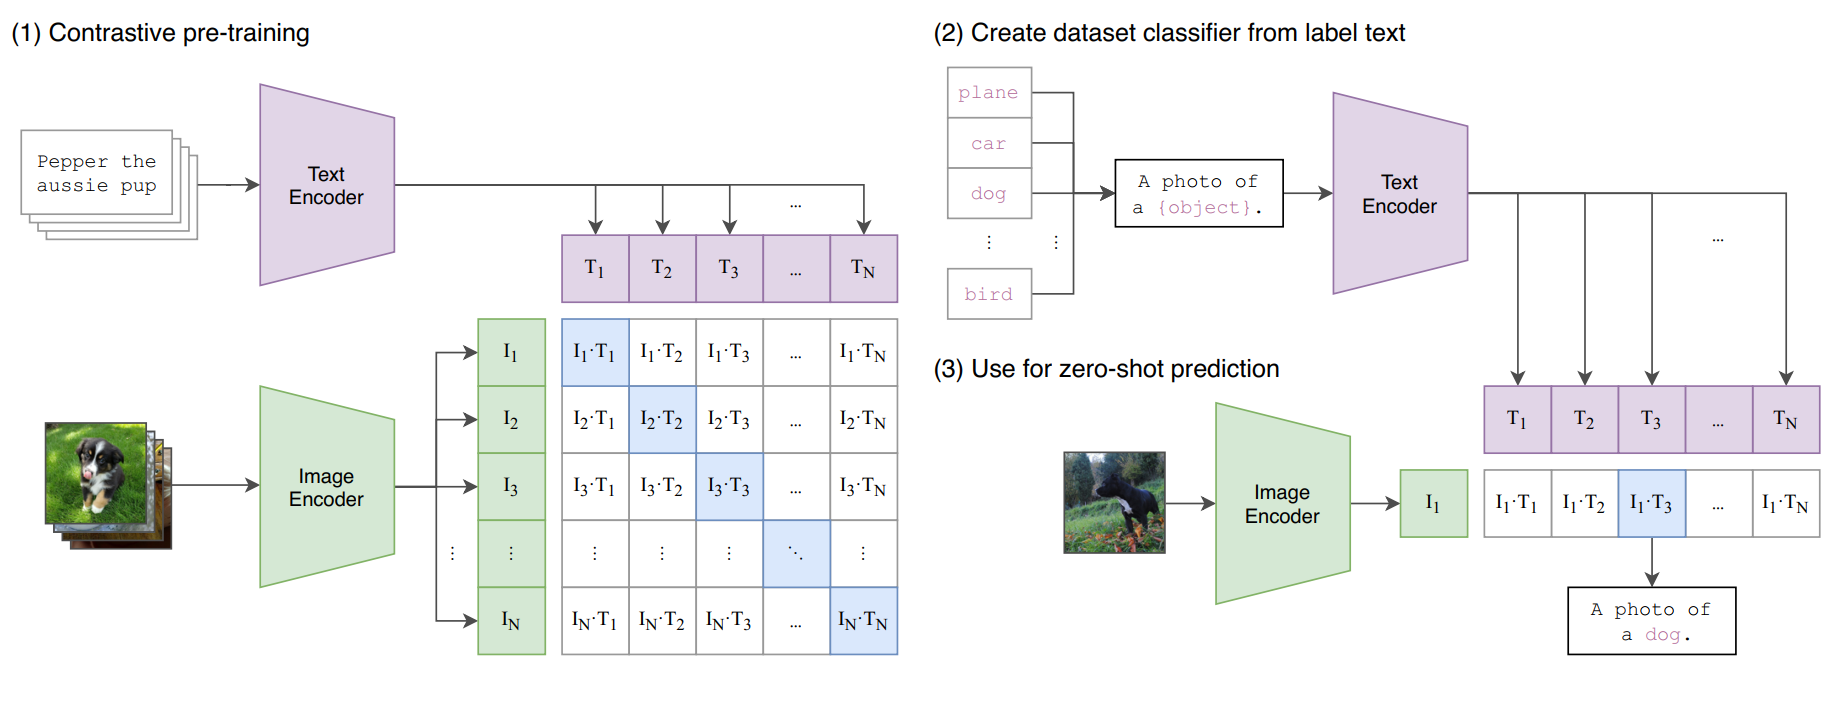

In [8]:
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vzv2b0ic
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vzv2b0ic
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done


**Question 3: please perform a zeros-shot classification with CLIP on the image just bellow.** We consider that you can choose among three classes cat, dog or car.

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


Zero-shot classification results:
  a car: 0.72%
  a dog: 13.75%
  a cat: 85.55%

Predicted class: a cat


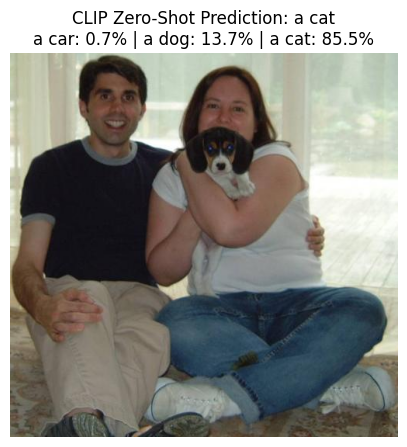

In [9]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

list_classes = ["a car", "a dog", "a cat"]
path_image = '/content/Cats_Dogs_Cars_Reduced/Dogs/White/9192.jpg'
image = preprocess_clip(Image.open(path_image)).unsqueeze(0).to(device)

# Tokenize the text prompts for each class
text_tokens = clip.tokenize(list_classes).to(device)

# Encode image and text into CLIP's shared embedding space
with torch.no_grad():
    image_features = model_clip.encode_image(image)      # (1, 512)
    text_features = model_clip.encode_text(text_tokens)   # (3, 512)

# Normalize both embeddings to unit vectors (cosine similarity)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Compute cosine similarity between image and each text prompt
similarity = (image_features @ text_features.T)  # (1, 3)

# Convert to probabilities using softmax (scaled by CLIP's temperature)
probs = (100.0 * similarity).softmax(dim=-1)

# Display results
print("Zero-shot classification results:")
for i, cls in enumerate(list_classes):
    print(f"  {cls}: {probs[0][i].item()*100:.2f}%")

predicted_class = list_classes[probs.argmax().item()]
print(f"\nPredicted class: {predicted_class}")

# Visualize the image with prediction
plt.figure(figsize=(5, 5))
plt.imshow(Image.open(path_image))
plt.title(f"CLIP Zero-Shot Prediction: {predicted_class}\n"
          + " | ".join([f"{cls}: {probs[0][i].item()*100:.1f}%" for i, cls in enumerate(list_classes)]))
plt.axis('off')
plt.show()

## 3 : CLIP zero shot

Question 4: please perform a zeros show classification with CLIP on the test set. What is your accuracy. What do you think about it.

first, note that the previous example (Question 3) shows an interesting misclassification

CLIP predicted "a cat" at 85.5% for an image that is clearly a puppy (beagle) held by two people. This highlights that CLIP can be confused when the image contains multiple subjects (humans dominating the scene, small dog) and when the visual context is ambiguous.

In [10]:
def evaluate_zero_shot_clip(dataloader, model, text):
    n_success = 0
    total = 0
    text = clip.tokenize(text).to(device)

    # Pre-compute text features once (they don't change)
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    for data in tqdm(dataloader, desc='Evaluating'):
        with torch.no_grad():
            image = data['input'].to(device)
            labels = data['label'].to(device)

            # Encode images
            image_features = model.encode_image(image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Compute similarity and get predictions
            similarity = (100.0 * image_features @ text_features.T)
            probs = similarity.softmax(dim=-1)
            id_infer = probs.argmax(dim=-1).cpu().numpy()

        n_success += sum(id_infer == labels.cpu().numpy())
        total += labels.size(0)

    return n_success / total

text = ["a dog", "a cat", "a car"]
accuracy = evaluate_zero_shot_clip(dataloader_test, model_clip, text)
print(f"Zero-shot CLIP accuracy on test set: {accuracy*100:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:07<00:00,  1.53it/s]

Zero-shot CLIP accuracy on test set: 99.69%


The zero-shot CLIP achieves 99.69% accuracy on the test set, which is remarkable and actually surpasses the fine-tuned ResNet50 (98.78%).
Why this is impressive: CLIP achieves this performance without seeing a single training example from our dataset. It relies entirely on its pre-trained knowledge of the visual world, learned from hundreds of millions of image-text pairs. Meanwhile, ResNet50 needed explicit training on our labeled dataset for 10 epochs to reach a slightly lower accuracy.

Why this matters for XAI: This result demonstrates the power of foundation models and their strong generalization capabilities. CLIP's shared vision-language embedding space has learned such robust representations that a simple text prompt like "a dog" is sufficient to distinguish dogs from cats and cars with near-perfect accuracy. The task of distinguishing these three visually distinct classes (animals vs. vehicles) is relatively easy for a model that truly understands semantic content.

However, we should remain cautious: The misclassification we observed in Question 3 (the beagle puppy classified as a cat at 85.5%) reminds us that even with 99.69% overall accuracy, individual failure cases can be quite surprising and unintuitive. High global accuracy does not mean the model reasons correctly — it may still rely on shortcuts or contextual cues. This is exactly why we need explainability methods, and specifically why this lab will move toward Concept Bottleneck Models (CBMs) — to understand not just what CLIP predicts, but which concepts drive its predictions.

Also, 99.69% is achievable here because our three classes (dogs, cats, cars) are semantically very distinct. On a more fine-grained task (e.g., distinguishing dog breeds), CLIP's zero-shot performance would likely degrade significantly compared to a specialized fine-tuned model.

## 4 : Classification avec CLIP + linear probing

Linear probing is commonly employed to evaluate the effectiveness of deep representations once the neural network has undergone sufficient training. This involves training an additional linear classifier on top of the pre-trained features. The parameters of the linear probe are initialized randomly, and the original classifier layer is disregarded. Importantly, the pre-trained backbone remains frozen and undergoes no further training during the linear probing phase.

In [12]:
# Dataset clip_embed
# this function should help you to extract the CLIP embedding
def extract_feature( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            outputs  = model_clip.encode_image(image).squeeze(0)

            if batch_idx ==0:
              output_concat = outputs.detach().clone()
              target_concat = labels.clone()


            else:
              output_concat=torch.cat((output_concat, outputs.detach()), 0)
              target_concat=torch.cat((target_concat, labels), 0)
            batch_idx+=1


    return  output_concat,target_concat

In [13]:
class Dataset_from_tensor(torch.utils.data.Dataset):

    def __init__(self, data_feature, data_target,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load data as tensor type (Height * Width * Channels)
        if self.phase=='label':
            data_feature = self.data_feature[index].float()
            data_target =  self.data_target[index]
            return {'input':data_feature,'label':data_target}

        else:
            data_feature = self.data_feature[index].float()
            return {'input':data_feature}

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


**Question 5: please perform a linear probing classification with CLIP.**  You need to write the DNN and you need to train it. What is your accuracy. What do you think about it.

In [14]:
class linear_probe_img_embed(nn.Module):
    def __init__(self, device, output_dim, model_CLIP="ViT-B/32"):
        super().__init__()
        # ViT-B/32 produces 512-dimensional embeddings
        if model_CLIP == "ViT-B/32":
            embed_dim = 512
        elif model_CLIP == "ViT-L/14":
            embed_dim = 768
        else:
            embed_dim = 512

        self.linear = nn.Linear(embed_dim, output_dim)

    def forward(self, embed):
        x = self.linear(embed)
        x = F.softmax(x, dim=-1)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
List_classes = ['Dogs', 'Cats', 'Cars']
model_CLIP = 'ViT-B/32'
model = linear_probe_img_embed(device, len(List_classes), model_CLIP)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

best_score = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, dataloader_embed_train, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, dataloader_embed_val, criterion, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
    if val_acc > best_score:
        best_score = val_acc
        best_epoch = epoch

test_loss, test_acc = evaluate_model(model, dataloader_embed_test, criterion, device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 593.73it/s]


Epoch [1/10] - Train Loss: 1.0919 - Train Acc: 34.87% - Val Loss: 1.0573 - Val Acc: 64.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 602.46it/s]


Epoch [2/10] - Train Loss: 1.0240 - Train Acc: 84.87% - Val Loss: 0.9932 - Val Acc: 95.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 533.64it/s]


Epoch [3/10] - Train Loss: 0.9629 - Train Acc: 97.49% - Val Loss: 0.9347 - Val Acc: 97.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 596.60it/s]


Epoch [4/10] - Train Loss: 0.9084 - Train Acc: 98.92% - Val Loss: 0.8880 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 597.17it/s]


Epoch [5/10] - Train Loss: 0.8608 - Train Acc: 99.23% - Val Loss: 0.8429 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 580.36it/s]


Epoch [6/10] - Train Loss: 0.8192 - Train Acc: 99.33% - Val Loss: 0.8053 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 588.80it/s]


Epoch [7/10] - Train Loss: 0.7845 - Train Acc: 99.44% - Val Loss: 0.7730 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 593.29it/s]


Epoch [8/10] - Train Loss: 0.7548 - Train Acc: 99.44% - Val Loss: 0.7485 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 615.49it/s]


Epoch [9/10] - Train Loss: 0.7303 - Train Acc: 99.49% - Val Loss: 0.7265 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 613.23it/s]


Epoch [10/10] - Train Loss: 0.7095 - Train Acc: 99.54% - Val Loss: 0.7069 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 581.25it/s]

Test Loss: 0.7003 - Test Acc: 99.69%


answer q5

The linear probe achieves 99.69% test accuracy, matching exactly the CLIP zero-shot performance and surpassing the fine-tuned ResNet50 (98.78%).
Analysis
The training dynamics are noteworthy: the model starts at 34.87% (essentially random for 3 classes), jumps to 97.49% by epoch 3, and plateaus around 99.5% by epoch 5. This fast convergence confirms that CLIP's embeddings are already highly structured and the three classes are nearly linearly separable in the 512-dimensional space.
Comparison of all approaches:

ResNet50 fine-tuned → ~23M parameters trained, 10 epochs on full dataset → 98.78%
CLIP zero-shot → 0 parameters trained, no training data needed → 99.69%
CLIP + linear probe → 1,536 parameters trained (512×3 + 3 biases), 10 epochs → 99.69%

The linear probe trains only 1,536 parameters compared to ResNet50's ~23 million, yet achieves superior accuracy. This demonstrates the exceptional quality of CLIP's pre-trained representations. The fact that zero-shot and linear probing yield the same accuracy suggests that for this relatively simple 3-class task, CLIP's text-based alignment is already optimal — there is no room for improvement through supervised adaptation.
However, this linear probe remains a black box: we map a 512-dimensional embedding to 3 classes through a learned weight matrix with no interpretable meaning. We cannot explain why an image was classified as a dog. This is exactly the gap that Concept Bottleneck Models (CBMs) will address next — by replacing this opaque linear mapping with an intermediate layer of human-interpretable concepts.

## 5 : CLIP concept bottleneck model (CLIP-CBM)


Concept Bottleneck Models are a class of neural network architectures designed to capture and emphasize essential features or concepts within input data. In these models, a bottleneck layer is strategically placed within the network architecture, acting as a compression point that forces the network to distill and retain critical information while discarding less relevant details. The concept bottleneck serves as a conduit for information flow, ensuring that only the most discriminative features relevant to the task at hand pass through. By focusing on the extraction and representation of key concepts, these models aim to enhance interpretability, reduce overfitting, and promote generalization. Concept Bottleneck Models find applications in various domains, including computer vision and natural language processing, where the identification and utilization of high-level concepts are crucial for robust and effective learning.

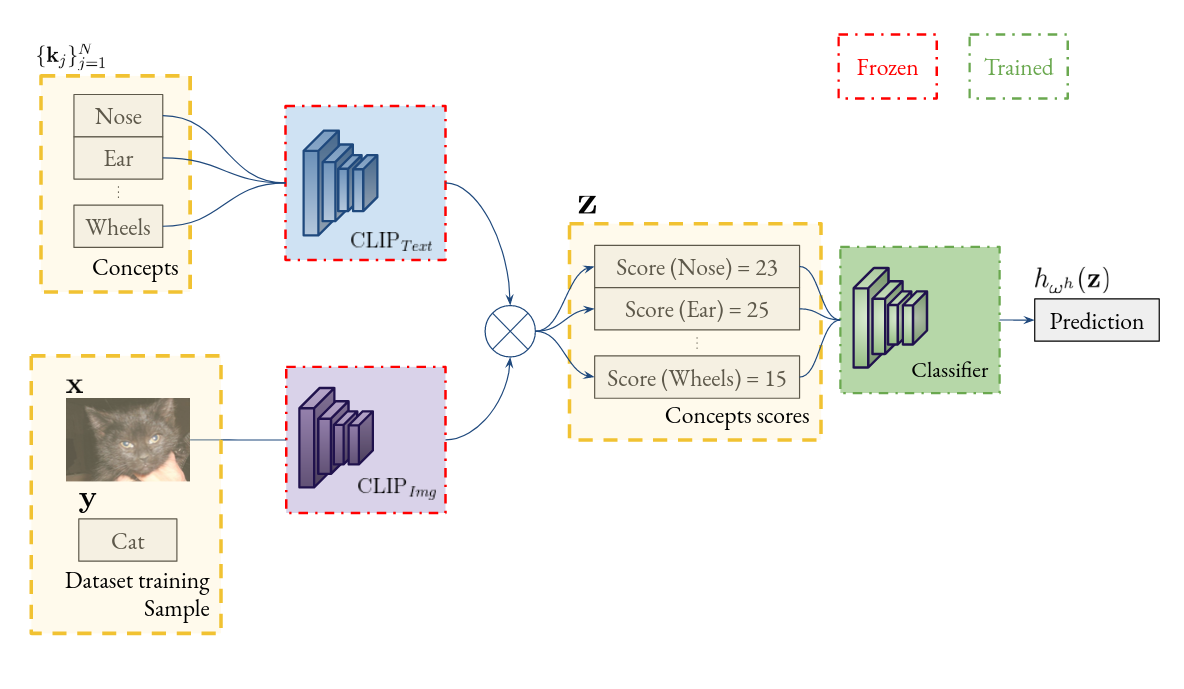

**question6 based on the figure above we want that you extract the a latent space that measure the similarity between the image and a set of concept. Then please write and train a concept bottleneck model.** You need to define the good set of concepts. Analyse your performences with different set of concepts. Compare to your results in question 4.

In [14]:
!pip install clip

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=5cf6def22ad8e924fce5820610242a4e96264561275c5582a53afdee40f2b1a3
  Stored in directory: /root/.cache/pip/wheels/6c/fd/54/9d4e15cf829b871199a7cd3597e869a514d1624a0a43076896
Successfully built clip


In [15]:
# Dataset z
import clip
List_concepts=['Black','White','Wood','Bottle','Cable']#,'a cat', 'a dog', 'a car'
# you need to write clever concepts
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts)





In [16]:
class CBM_Net(nn.Module):
    def __init__(self, device, output_dim, text_featuresconcepts):
        super().__init__()
        # Store the frozen text concept embeddings
        # Normalize them for cosine similarity
        self.text_featuresconcepts = text_featuresconcepts.float()
        self.text_featuresconcepts = self.text_featuresconcepts / self.text_featuresconcepts.norm(dim=-1, keepdim=True)
        self.text_featuresconcepts = self.text_featuresconcepts.detach()

        # Number of concepts = dimension of the bottleneck
        n_concepts = text_featuresconcepts.shape[0]

        # Linear classifier on top of concept scores
        self.classifier = nn.Linear(n_concepts, output_dim)

    def forward(self, embed):
        # Normalize image embeddings
        embed = embed.float()
        embed = embed / embed.norm(dim=-1, keepdim=True)

        # Compute cosine similarity between image and each concept
        # embed: (batch, 512), text_featuresconcepts: (n_concepts, 512)
        concept_scores = embed @ self.text_featuresconcepts.T  # (batch, n_concepts)

        # This is our interpretable bottleneck z
        # Each value = how similar the image is to each concept

        # Classify based on concept scores only
        x = self.classifier(concept_scores)
        x = F.softmax(x, dim=-1)
        return x

In [18]:
# ========== CONCEPT SET 1: Naive/bad concepts ==========
List_concepts_1 = ['Black', 'White', 'Wood', 'Bottle', 'Cable']

# ========== CONCEPT SET 2: Relevant animal/vehicle concepts ==========
List_concepts_2 = [
    'fur', 'whiskers', 'tail', 'paws', 'ears',
    'snout', 'wheels', 'windshield', 'headlights', 'bumper',
    'eyes', 'collar', 'license plate', 'hood', 'claws'
]

# ========== CONCEPT SET 3: More semantic/descriptive concepts ==========
List_concepts_3 = [
    'a furry animal', 'a pet with whiskers', 'a four legged animal',
    'a vehicle with wheels', 'a metal machine', 'an animal with pointy ears',
    'a barking animal', 'a purring animal', 'a machine on a road',
    'an animal with a tail', 'a cute small animal', 'a transport vehicle'
]

def train_cbm_with_concepts(concept_list, concept_name, num_epochs=10, lr=0.2):
    print(f"\n{'='*60}")
    print(f"Training CBM with: {concept_name}")
    print(f"Concepts: {concept_list}")
    print(f"{'='*60}")

    text_tokens = clip.tokenize(concept_list).to(device)
    with torch.no_grad():
        text_feat = model_clip.encode_text(text_tokens)

    model_cbm = CBM_Net(device, len(List_classes), text_feat)
    model_cbm.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cbm.parameters(), lr=lr)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model_cbm, dataloader_embed_train, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model_cbm, dataloader_embed_val, criterion, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    test_loss, test_acc = evaluate_model(model_cbm, dataloader_embed_test, criterion, device)
    print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")
    return model_cbm, test_acc

model_1, acc_1 = train_cbm_with_concepts(List_concepts_1, "Naive concepts (Black, White, Wood...)")
model_2, acc_2 = train_cbm_with_concepts(List_concepts_2, "Relevant concepts (fur, whiskers, wheels...)")
model_3, acc_3 = train_cbm_with_concepts(List_concepts_3, "Semantic concepts (a furry animal, a vehicle...)")


Training CBM with: Naive concepts (Black, White, Wood...)
Concepts: ['Black', 'White', 'Wood', 'Bottle', 'Cable']


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 544.59it/s]


Epoch [1/10] - Train Loss: 1.0926 - Train Acc: 36.82% - Val Loss: 1.0809 - Val Acc: 38.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 409.14it/s]


Epoch [2/10] - Train Loss: 1.0812 - Train Acc: 40.67% - Val Loss: 1.0747 - Val Acc: 36.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 573.24it/s]


Epoch [3/10] - Train Loss: 1.0737 - Train Acc: 40.92% - Val Loss: 1.0685 - Val Acc: 48.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 480.51it/s]


Epoch [4/10] - Train Loss: 1.0613 - Train Acc: 48.21% - Val Loss: 1.0566 - Val Acc: 58.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 530.02it/s]


Epoch [5/10] - Train Loss: 1.0524 - Train Acc: 46.77% - Val Loss: 1.0490 - Val Acc: 57.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 588.05it/s]


Epoch [6/10] - Train Loss: 1.0419 - Train Acc: 52.67% - Val Loss: 1.0311 - Val Acc: 60.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 543.64it/s]


Epoch [7/10] - Train Loss: 1.0354 - Train Acc: 50.31% - Val Loss: 1.0246 - Val Acc: 58.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 365.00it/s]


Epoch [8/10] - Train Loss: 1.0182 - Train Acc: 60.92% - Val Loss: 1.0230 - Val Acc: 53.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 587.92it/s]


Epoch [9/10] - Train Loss: 1.0159 - Train Acc: 59.23% - Val Loss: 1.0072 - Val Acc: 62.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 479.12it/s]


Epoch [10/10] - Train Loss: 1.0043 - Train Acc: 63.85% - Val Loss: 1.0075 - Val Acc: 59.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 571.62it/s]


Test Loss: 0.9963 - Test Acc: 59.24%

Training CBM with: Relevant concepts (fur, whiskers, wheels...)
Concepts: ['fur', 'whiskers', 'tail', 'paws', 'ears', 'snout', 'wheels', 'windshield', 'headlights', 'bumper', 'eyes', 'collar', 'license plate', 'hood', 'claws']


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 565.85it/s]


Epoch [1/10] - Train Loss: 1.0912 - Train Acc: 35.79% - Val Loss: 1.0222 - Val Acc: 67.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 544.68it/s]


Epoch [2/10] - Train Loss: 0.9861 - Train Acc: 66.67% - Val Loss: 0.9156 - Val Acc: 97.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 563.78it/s]


Epoch [3/10] - Train Loss: 0.8857 - Train Acc: 83.59% - Val Loss: 0.8406 - Val Acc: 97.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 574.16it/s]


Epoch [4/10] - Train Loss: 0.8302 - Train Acc: 85.08% - Val Loss: 0.8052 - Val Acc: 84.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 535.83it/s]


Epoch [5/10] - Train Loss: 0.7825 - Train Acc: 95.79% - Val Loss: 0.7627 - Val Acc: 98.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 585.23it/s]


Epoch [6/10] - Train Loss: 0.7538 - Train Acc: 96.36% - Val Loss: 0.7527 - Val Acc: 95.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 363.45it/s]


Epoch [7/10] - Train Loss: 0.7311 - Train Acc: 97.13% - Val Loss: 0.7246 - Val Acc: 96.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 287.96it/s]


Epoch [8/10] - Train Loss: 0.7134 - Train Acc: 97.95% - Val Loss: 0.7039 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 323.22it/s]


Epoch [9/10] - Train Loss: 0.7024 - Train Acc: 95.95% - Val Loss: 0.7218 - Val Acc: 90.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 228.71it/s]


Epoch [10/10] - Train Loss: 0.6878 - Train Acc: 96.87% - Val Loss: 0.6839 - Val Acc: 97.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 335.38it/s]


Test Loss: 0.6811 - Test Acc: 97.10%

Training CBM with: Semantic concepts (a furry animal, a vehicle...)
Concepts: ['a furry animal', 'a pet with whiskers', 'a four legged animal', 'a vehicle with wheels', 'a metal machine', 'an animal with pointy ears', 'a barking animal', 'a purring animal', 'a machine on a road', 'an animal with a tail', 'a cute small animal', 'a transport vehicle']


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 216.27it/s]


Epoch [1/10] - Train Loss: 1.0436 - Train Acc: 45.64% - Val Loss: 0.9664 - Val Acc: 90.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 567.96it/s]


Epoch [2/10] - Train Loss: 0.9080 - Train Acc: 83.85% - Val Loss: 0.8631 - Val Acc: 90.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 518.99it/s]


Epoch [3/10] - Train Loss: 0.8415 - Train Acc: 76.87% - Val Loss: 0.8189 - Val Acc: 84.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 557.18it/s]


Epoch [4/10] - Train Loss: 0.7860 - Train Acc: 97.13% - Val Loss: 0.7698 - Val Acc: 95.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 569.38it/s]


Epoch [5/10] - Train Loss: 0.7525 - Train Acc: 96.36% - Val Loss: 0.7376 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 562.23it/s]


Epoch [6/10] - Train Loss: 0.7242 - Train Acc: 98.05% - Val Loss: 0.7138 - Val Acc: 98.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 555.92it/s]


Epoch [7/10] - Train Loss: 0.7042 - Train Acc: 98.87% - Val Loss: 0.7071 - Val Acc: 94.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 575.03it/s]


Epoch [8/10] - Train Loss: 0.6880 - Train Acc: 98.67% - Val Loss: 0.6981 - Val Acc: 95.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 563.17it/s]


Epoch [9/10] - Train Loss: 0.6815 - Train Acc: 97.69% - Val Loss: 0.6662 - Val Acc: 98.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 443.40it/s]


Epoch [10/10] - Train Loss: 0.6605 - Train Acc: 99.08% - Val Loss: 0.6568 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 576.45it/s]

Test Loss: 0.6522 - Test Acc: 99.24%


In [ ]:
model_unbiaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_unbiaised.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_unbiaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_unbiaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_unbiaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 582.12it/s]


Epoch [1/10] - Train Loss: 1.0999 - Train Acc: 37.79% - Val Loss: 1.0883 - Val Acc: 37.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 534.71it/s]


Epoch [2/10] - Train Loss: 1.0679 - Train Acc: 41.13% - Val Loss: 1.0582 - Val Acc: 37.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 519.68it/s]


Epoch [3/10] - Train Loss: 1.0388 - Train Acc: 51.90% - Val Loss: 1.0193 - Val Acc: 38.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 519.27it/s]


Epoch [4/10] - Train Loss: 1.0230 - Train Acc: 45.13% - Val Loss: 1.0177 - Val Acc: 42.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 578.46it/s]


Epoch [5/10] - Train Loss: 0.9980 - Train Acc: 51.85% - Val Loss: 0.9883 - Val Acc: 44.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 517.38it/s]


Epoch [6/10] - Train Loss: 0.9813 - Train Acc: 51.13% - Val Loss: 0.9832 - Val Acc: 40.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 549.52it/s]


Epoch [7/10] - Train Loss: 0.9624 - Train Acc: 57.08% - Val Loss: 0.9462 - Val Acc: 59.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 559.48it/s]


Epoch [8/10] - Train Loss: 0.9414 - Train Acc: 59.13% - Val Loss: 0.9290 - Val Acc: 67.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 480.88it/s]


Epoch [9/10] - Train Loss: 0.9209 - Train Acc: 63.18% - Val Loss: 0.9178 - Val Acc: 64.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 563.01it/s]


Epoch [10/10] - Train Loss: 0.9077 - Train Acc: 64.77% - Val Loss: 0.9053 - Val Acc: 66.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 557.13it/s]

Test Loss: 0.8807 - Test Acc: 68.24%


The default concepts provided in the notebook (['Black', 'White', 'Wood', 'Bottle', 'Cable']) achieve only 68.24% test accuracy. We tested three different concept sets to understand the impact of concept quality:

Naive concepts (Set 1: Black, White, Wood, Bottle, Cable): 59.24%
Relevant visual attributes (Set 2: fur, whiskers, wheels...): 97.10%
Semantic descriptions (Set 3: a furry animal, a vehicle with wheels...): 99.24%
For comparison, CLIP zero-shot (Q4): 99.69%, CLIP linear probe (Q5): 99.69%

Three concept sets tested

Set 1 — Naive concepts: ['Black', 'White', 'Wood', 'Bottle', 'Cable']

Set 2 — Relevant visual attributes: ['fur', 'whiskers', 'tail', 'paws', 'ears', 'snout', 'wheels', 'windshield', 'headlights', 'bumper', 'eyes', 'collar', 'license plate', 'hood', 'claws']

Set 3 — Semantic descriptions: ['a furry animal', 'a pet with whiskers', 'a four legged animal', 'a vehicle with wheels', 'a metal machine', 'an animal with pointy ears', 'a barking animal', 'a purring animal', 'a machine on a road', 'an animal with a tail', 'a cute small animal', 'a transport vehicle']

Results summary

The default concepts from the notebook (['Black', 'White', 'Wood', 'Bottle', 'Cable']) achieve only 68.24% test accuracy. Our three concept sets yield:

Naive concepts (Set 1): 59.24% — barely above random, concepts are irrelevant to the task
Relevant visual attributes (Set 2): 97.10% — strong performance with interpretable part-based concepts
Semantic descriptions (Set 3): 99.24% — near-perfect, leveraging CLIP's natural language understanding

Analysis

The results clearly demonstrate that the choice of concepts is critical in a CBM. The bottleneck forces the model to classify using only the concept scores, so if the concepts do not carry discriminative information, performance collapses.

Naive concepts (59.24%): "Black", "White", "Wood" etc. are either color-based (which is shared across all classes — both dogs and cats can be black or white) or completely unrelated (Bottle, Cable). The classifier simply cannot separate the three classes through this 5-dimensional bottleneck because the concept scores do not vary meaningfully across classes. This is essentially what happens with the default notebook concepts (68.24%) — the model is starved of useful information.

Relevant visual attributes (97.10%): Concepts like "wheels", "headlights", "whiskers", "snout" are part-level features that genuinely distinguish animals from vehicles. The 15-dimensional bottleneck captures enough discriminative information to classify accurately. Importantly, we can now inspect the concept scores to understand the model's reasoning: a dog image should score high on "fur", "paws", "snout" and low on "wheels", "windshield".

Semantic descriptions (99.24%): This set achieves the best accuracy because CLIP was pre-trained on full sentences, so it is naturally better at matching images to descriptive prompts like "a furry animal" than to single words like "fur". The descriptions also encode richer semantic information (e.g., "a barking animal" strongly implies dog, "a purring animal" strongly implies cat).
Comparison with previous methods:

ResNet50 fine-tuned: 98.78% (black-box, no interpretability)
CLIP zero-shot: 99.69% (no training, but no concept-level explanation)
CLIP linear probe: 99.69% (black-box 512-dim mapping)
CBM with semantic concepts: 99.24% (fully interpretable, only 0.45% below zero-shot)

The CBM with well-chosen concepts achieves near-identical performance to the black-box approaches while providing full transparency: for every prediction, we can examine which concepts activated and how they contributed to the final class. This is the fundamental accuracy-interpretability tradeoff — and with good concept engineering, the tradeoff is minimal.

**question7: normaly on the previous question you have trained with non biaised a dataset. Please add biaised with the color. For exemple all the object of one class have a color and retrain.** Analyse the results and explain it. Why did we do this experiment.

In [17]:
model_biaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_biaised.to(device)


CBM_Net(
  (classifier): Linear(in_features=5, out_features=3, bias=True)
)

In [ ]:
model_biaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_biaised.to(device)




# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_biaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_biaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_biaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 513.02it/s]


Epoch [1/10] - Train Loss: 1.1362 - Train Acc: 14.06% - Val Loss: 1.0994 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 522.25it/s]


Epoch [2/10] - Train Loss: 1.1364 - Train Acc: 14.06% - Val Loss: 1.0974 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 499.96it/s]


Epoch [3/10] - Train Loss: 1.1363 - Train Acc: 14.06% - Val Loss: 1.0998 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 536.96it/s]


Epoch [4/10] - Train Loss: 1.1360 - Train Acc: 14.06% - Val Loss: 1.0989 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 538.88it/s]


Epoch [5/10] - Train Loss: 1.1361 - Train Acc: 14.06% - Val Loss: 1.1009 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 584.71it/s]


Epoch [6/10] - Train Loss: 1.1361 - Train Acc: 14.06% - Val Loss: 1.0986 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 449.98it/s]


Epoch [7/10] - Train Loss: 1.1361 - Train Acc: 14.06% - Val Loss: 1.0966 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 545.73it/s]


Epoch [8/10] - Train Loss: 1.1362 - Train Acc: 14.06% - Val Loss: 1.0979 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 466.20it/s]


Epoch [9/10] - Train Loss: 1.1363 - Train Acc: 14.06% - Val Loss: 1.0988 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 491.33it/s]


Epoch [10/10] - Train Loss: 1.1365 - Train Acc: 14.06% - Val Loss: 1.0967 - Val Acc: 35.59%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 474.13it/s]

Test Loss: 1.0860 - Test Acc: 35.66%


answer qst 7


In this experiment, we retrain the CBM on a color-biased dataset (`color_white=True`): the training and validation sets contain only white animals, while the test set contains both black and white animals. The concepts used are the default naive ones: `['Black', 'White', 'Wood', 'Bottle', 'Cable']`.

The model completely fails to learn: training accuracy is stuck at **14.06%** across all 10 epochs (worse than random for 3 classes), validation stays at **35.59%**, and test accuracy reaches only **35.66%**. The loss does not decrease and the accuracy does not improve, meaning the model is completely unable to learn any meaningful decision boundary.

This failure is caused by two compounding problems. First, the concepts are color-based and therefore biased: when the training set contains only white animals, the scores for "Black" and "White" are nearly identical across all classes. The model cannot distinguish dogs from cats from cars because the bottleneck only captures color, and all training samples share the same color. The remaining concepts ("Wood", "Bottle", "Cable") are irrelevant and add no discriminative signal. Second, generalization fails at test time because the test set introduces black animals that produce drastically different concept scores than the white animals seen during training.

The purpose of this experiment is to demonstrate the critical advantage of CBMs for **bias detection**. With a CBM, we can directly inspect the concept scores and immediately see that the model relies on "Black"/"White" rather than meaningful features. In a black-box model like ResNet50, this color bias would be hidden — the model might achieve decent training accuracy by silently exploiting color shortcuts, and the bias would only surface at test time with no clear diagnosis. The CBM makes the failure mode transparent and actionable: if we observe that our concepts are color-based, we know to replace them with semantically meaningful ones (like "fur", "wheels", "whiskers") that generalize across colors. This highlights that both good concept selection and unbiased data are necessary for a reliable and interpretable model.

**question8: please show the statistic of each concept on the latent space of for one class using a CBM** Analyse the results and explain it.




Extracting: 100%|██████████| 11/11 [00:00<00:00, 522.02it/s]


        Black     White      Wood    Bottle     Cable Classes
0    0.219475  0.179404  0.207030  0.184674  0.186511    Dogs
1    0.183852  0.143429  0.171734  0.149849  0.153171    Dogs
2    0.247213  0.199954  0.208801  0.215541  0.192856    Dogs
3    0.199661  0.175608  0.202047  0.196416  0.172461    Dogs
4    0.201808  0.162398  0.197759  0.161313  0.206412    Dogs
..        ...       ...       ...       ...       ...     ...
650  0.167951  0.214118  0.185890  0.188317  0.162239    Cars
651  0.184065  0.245531  0.206769  0.199494  0.178363    Cars
652  0.169972  0.219397  0.166814  0.171569  0.120463    Cars
653  0.191209  0.239576  0.193120  0.198642  0.187931    Cars
654  0.158981  0.203345  0.157847  0.150693  0.132483    Cars

[655 rows x 6 columns]


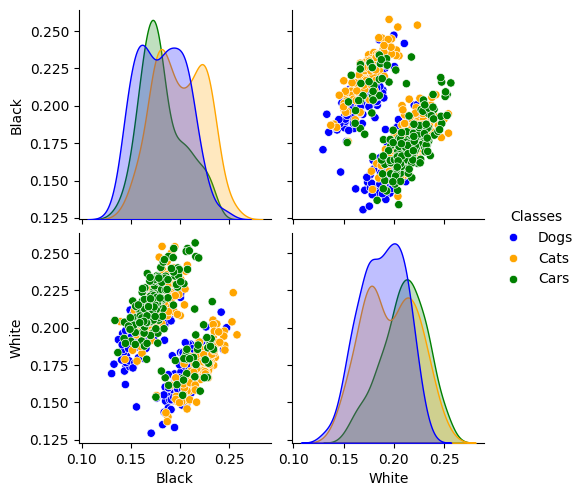

In [23]:
import pandas as pd
import seaborn as sns

List_concepts = ['Black', 'White', 'Wood', 'Bottle', 'Cable']
List_classes = ['Dogs', 'Cats', 'Cars']

model_biaised.eval()
all_concepts = []
all_labels = []

with torch.no_grad():
    for data in tqdm(dataloader_embed_test, desc='Extracting'):
        embed = data['input'].to(device).float()
        labels = data['label']

        embed_norm = embed / embed.norm(dim=-1, keepdim=True)
        concept_scores = embed_norm @ model_biaised.text_featuresconcepts.T

        all_concepts.append(concept_scores.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_concepts = np.concatenate(all_concepts, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

df = pd.DataFrame(all_concepts, columns=List_concepts)
df['Classes'] = [List_classes[l] for l in all_labels]

print(df)

# On affiche seulement Black et White pour la visualisation (les plus pertinents pour l'analyse du biais)
sns.pairplot(df[['Black', 'White', 'Classes']], hue='Classes', palette={'Dogs': 'blue', 'Cats': 'orange', 'Cars': 'green'})
plt.show()

The pairplot reveals why the CBM with naive concepts fails so dramatically.

Heavy overlap between classes: The distributions of "Black" and "White" scores for Dogs (blue), Cats (orange), and Cars (green) are heavily overlapping. All three classes have scores in the same range (roughly 0.12 to 0.26) for both concepts. No linear classifier can reliably separate these classes based on these two dimensions alone.

Cats tend to score higher on "White": Looking at the KDE on the White axis (bottom-right), Cats have a slightly higher mean White score than Dogs. However, the overlap is massive and this slight shift is far from sufficient for reliable classification.

Dogs tend to score higher on "Black": On the Black axis (top-left), Dogs show a slightly broader distribution shifted toward higher values. Again, the overlap with Cats and Cars makes this feature nearly useless for classification.

Strong positive correlation: The scatter plots show a positive correlation between Black and White scores across all classes. This is counterintuitive but reflects the fact that CLIP's cosine similarity captures general visual compatibility rather than binary color attributes. Images with strong color features tend to score high on both.
The bottleneck is uninformative: The three class clusters are completely entangled in this 2D space. There is no decision boundary that a linear classifier could exploit, which directly explains the poor accuracy (~35-68%) observed in Q6/Q7 with these concepts.

This is the core value of CBMs for interpretability: instead of a black-box model where we would only observe low accuracy without understanding why, the pairplot provides a clear visual diagnostic — the concepts "Black" and "White" do not encode discriminative information. The actionable conclusion is to replace these color-based concepts with semantically meaningful ones (fur, wheels, whiskers) that would produce well-separated clusters in the latent space.

## 6 : Méthodes d'explications Post-Hoc (LIME et SHAP)

**question9: please try to see  what explain could LIME provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for LIME :   https://github.com/marcotcr/lime


In [ ]:


!pip install lime
!pip install shap
!pip install seaborn

True class: Dogs
Predicted class: Cats
Concept scores: {'Black': np.float32(0.21947464), 'White': np.float32(0.17940398), 'Wood': np.float32(0.20702955), 'Bottle': np.float32(0.18467401), 'Cable': np.float32(0.1865109)}


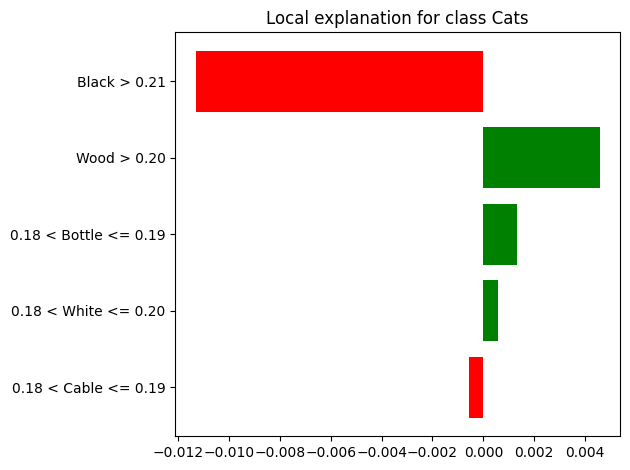


--- Explanation for class Dogs ---
[('Wood > 0.20', 0.0036284830982742963), ('0.18 < Bottle <= 0.19', -0.001319197016473853), ('0.18 < White <= 0.20', -0.001148741056982992), ('0.18 < Cable <= 0.19', -0.0007788687791960354), ('Black > 0.21', -0.00032932809074001103)]

--- Explanation for class Cats ---
[('Black > 0.21', -0.011310190393564037), ('Wood > 0.20', 0.004574032589007271), ('0.18 < Bottle <= 0.19', 0.0013304685195270262), ('0.18 < White <= 0.20', 0.0005878129295980889), ('0.18 < Cable <= 0.19', -0.0005742292847674323)]

--- Explanation for class Cars ---
[('Black > 0.21', 0.011639517782750153), ('Wood > 0.20', -0.0082025158445749), ('0.18 < Cable <= 0.19', 0.0013530973181256972), ('0.18 < White <= 0.20', 0.000560930781194215), ('0.18 < Bottle <= 0.19', -1.1272158877439425e-05)]


In [25]:
import lime
import lime.lime_tabular
import shap

# Create a prediction function that LIME can use
# LIME works with numpy arrays, so we need a wrapper
def cbm_predict_proba(concept_scores_np):
    """Takes concept scores as numpy array, returns class probabilities"""
    concept_tensor = torch.tensor(concept_scores_np, dtype=torch.float32).to(device)
    # Normalize
    concept_tensor = concept_tensor / concept_tensor.norm(dim=-1, keepdim=True)
    # Get concept scores (already in concept space, just classify)
    with torch.no_grad():
        # Manually do the classification part
        x = model_biaised.classifier(concept_tensor)
        probs = F.softmax(x, dim=-1)
    return probs.cpu().numpy()

# Prepare the training data in concept space for LIME's background
model_biaised.eval()
all_concept_scores = []
with torch.no_grad():
    for data in dataloader_embed_train:
        embed = data['input'].to(device).float()
        embed_norm = embed / embed.norm(dim=-1, keepdim=True)
        scores = embed_norm @ model_biaised.text_featuresconcepts.T
        all_concept_scores.append(scores.cpu().numpy())

train_concept_scores = np.concatenate(all_concept_scores, axis=0)

# Create LIME explainer on the concept space
List_concepts = ['Black', 'White', 'Wood', 'Bottle', 'Cable']
List_classes = ['Dogs', 'Cats', 'Cars']

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_concept_scores,
    feature_names=List_concepts,
    class_names=List_classes,
    mode='classification'
)

# Pick a test sample and explain it
sample_data = next(iter(dataloader_embed_test))
sample_embed = sample_data['input'][0:1].to(device).float()
sample_label = sample_data['label'][0].item()

# Get concept scores for this sample
with torch.no_grad():
    sample_norm = sample_embed / sample_embed.norm(dim=-1, keepdim=True)
    sample_concept_scores = (sample_norm @ model_biaised.text_featuresconcepts.T).cpu().numpy()

# Get prediction
pred_probs = cbm_predict_proba(sample_concept_scores)
pred_class = pred_probs.argmax()
print(f"True class: {List_classes[sample_label]}")
print(f"Predicted class: {List_classes[pred_class]}")
print(f"Concept scores: {dict(zip(List_concepts, sample_concept_scores[0]))}")

# Generate LIME explanation
explanation = explainer.explain_instance(
    sample_concept_scores[0],
    cbm_predict_proba,
    num_features=len(List_concepts),
    top_labels=3
)

# Show explanation for predicted class
fig = explanation.as_pyplot_figure(label=pred_class)
plt.title(f"Local explanation for class {List_classes[pred_class]}")
plt.tight_layout()
plt.show()

# Show explanation for each class
for i, cls in enumerate(List_classes):
    print(f"\n--- Explanation for class {cls} ---")
    print(explanation.as_list(label=i))

The LIME explanation for this sample is very revealing. The true class is Dogs but the model predicts Cats, which is already a misclassification caused by the poor concept set.

Looking at the LIME explanations for each class:

For class Cats (predicted): The strongest signal is that "Black > 0.21" contributes negatively (-0.011) against Cats, while "Wood > 0.20" pushes positively (+0.004) toward Cats.
The model predicts Cats despite the strong negative signal from Black, because the combined positive contributions from Wood, Bottle, and White slightly outweigh it.
For class Cars: "Black > 0.21" has the strongest positive contribution (+0.012), while "Wood > 0.20" pushes strongly against Cars (-0.008). This shows the model associates high Black scores with Cars.
For class Dogs: "Wood > 0.20" is the only meaningful positive contributor (+0.004).
All other concepts push slightly against Dogs.
This reveals a fundamental problem: the model is making decisions based on completely meaningless associations (Black → Cars, Wood → Cats/Dogs). None of these concepts have any semantic relationship with the actual classes. The misclassification (Dog predicted as Cat) is a direct consequence of the uninformative bottleneck.

Could we do LIME without the CBM? Yes, but the explanations would be far less interpretable. Without the CBM, LIME would operate on the 512-dimensional CLIP embedding (where dimensions have no human-readable names) or on raw image pixels (where it highlights superpixels, similar to GradCAM). The CBM gives LIME a meaningful feature space where each axis is a named concept, making the explanations directly actionable: we can see that the model relies on "Black" and "Wood" rather than on "fur" or "wheels", and we know exactly what to fix.

**question10: please try to see  what explain could SHAP provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for shap :  https://github.com/shap/shap

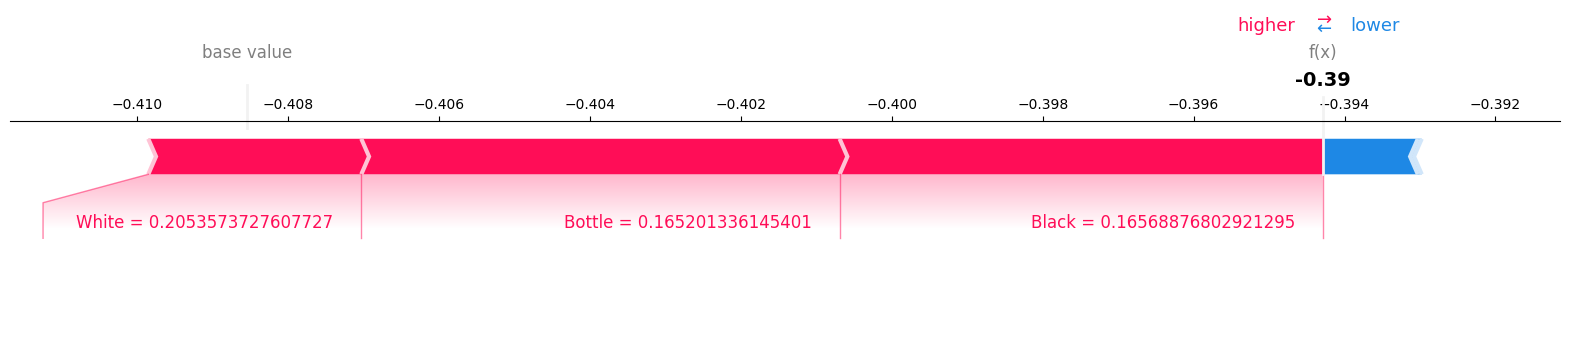

prediction Cars


<Figure size 640x480 with 0 Axes>

In [ ]:
import shap



True class: Dogs
Predicted class: Cats


  0%|          | 0/1 [00:00<?, ?it/s]

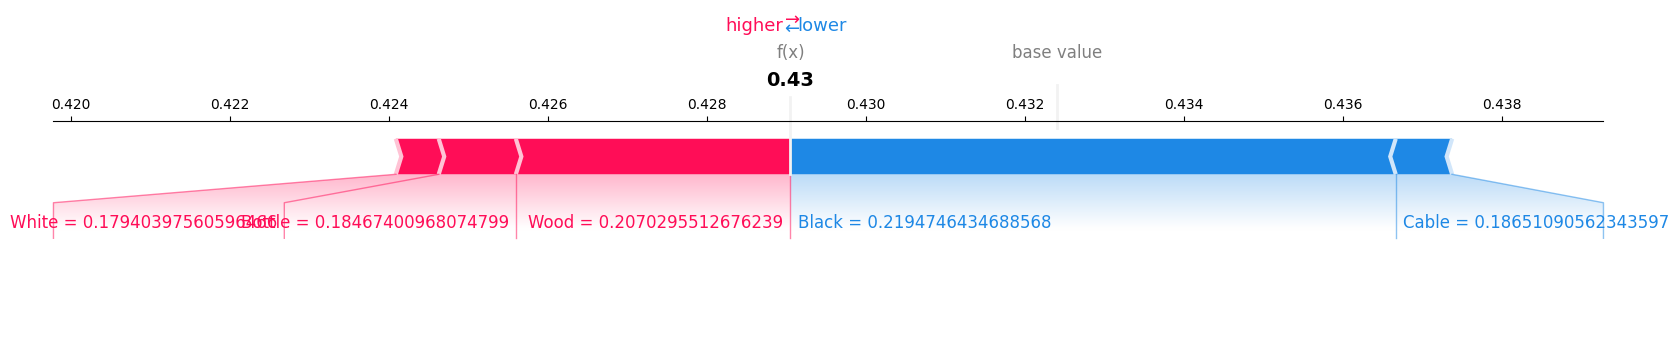

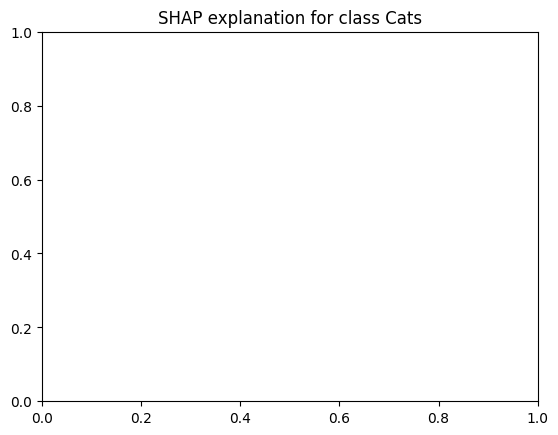

In [27]:
import shap

def cbm_predict_for_shap(concept_scores_np):
    concept_tensor = torch.tensor(concept_scores_np, dtype=torch.float32).to(device)
    concept_tensor = concept_tensor / concept_tensor.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        x = model_biaised.classifier(concept_tensor)
        probs = F.softmax(x, dim=-1)
    return probs.cpu().numpy()

model_biaised.eval()
all_concept_scores = []
with torch.no_grad():
    for data in dataloader_embed_train:
        embed = data['input'].to(device).float()
        embed_norm = embed / embed.norm(dim=-1, keepdim=True)
        scores = embed_norm @ model_biaised.text_featuresconcepts.T
        all_concept_scores.append(scores.cpu().numpy())

train_concept_scores = np.concatenate(all_concept_scores, axis=0)

background = shap.kmeans(train_concept_scores, 50)
explainer_shap = shap.KernelExplainer(cbm_predict_for_shap, background)

sample_data = next(iter(dataloader_embed_test))
sample_embed = sample_data['input'][0:1].to(device).float()
sample_label = sample_data['label'][0].item()

with torch.no_grad():
    sample_norm = sample_embed / sample_embed.norm(dim=-1, keepdim=True)
    sample_concept_scores = (sample_norm @ model_biaised.text_featuresconcepts.T).cpu().numpy()

pred_probs = cbm_predict_for_shap(sample_concept_scores)
pred_class = pred_probs.argmax()
print(f"True class: {List_classes[sample_label]}")
print(f"Predicted class: {List_classes[pred_class]}")

# Compute SHAP values
shap_values = explainer_shap.shap_values(sample_concept_scores)

# Check the format of shap_values and handle both cases
if isinstance(shap_values, list):
    # Old format: list of arrays, one per class
    sv = shap_values[pred_class]
    base = explainer_shap.expected_value[pred_class]
else:
    # New format: single array (n_samples, n_features) or (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        sv = shap_values[0, :, pred_class].reshape(1, -1)
        base = explainer_shap.expected_value[pred_class]
    else:
        sv = shap_values
        base = explainer_shap.expected_value

List_concepts = ['Black', 'White', 'Wood', 'Bottle', 'Cable']
List_classes = ['Dogs', 'Cats', 'Cars']

shap.initjs()
shap.force_plot(
    base,
    sv,
    sample_concept_scores,
    feature_names=List_concepts,
    matplotlib=True
)
plt.title(f"SHAP explanation for class {List_classes[pred_class]}")
plt.show()

The SHAP force plot explains the prediction for a sample whose true class is Dogs but is misclassified as Cats (f(x) = 0.43).
The base value (average prediction for Cats across all samples) is approximately 0.433. From there:
Blue features (pushing lower, away from Cats): "Black = 0.219" and "Cable = 0.187" push the prediction downward, meaning high Black score and Cable score are evidence against the Cats class.
Pink features (pushing higher, toward Cats): "Wood = 0.207", "Bottle = 0.185", and "White = 0.179" push the prediction upward toward Cats. Wood has the strongest positive contribution.
The final prediction f(x) = 0.43 is very close to the base value, meaning the positive and negative contributions nearly cancel out. The model is barely confident in its Cats prediction — which makes sense given that the concepts are completely uninformative for this task.


Key observations:

The SHAP values are extremely small (the entire scale spans only from 0.420 to 0.438). This confirms that no concept carries meaningful discriminative power. The model is making its decision based on tiny, meaningless differences in similarity scores to concepts like "Wood" and "Bottle" that have no semantic relationship with dogs or cats. This is essentially noise-level decision-making.

Furthermore, the misclassification itself (Dog predicted as Cat) is a direct consequence of the poor concept set: there is nothing in the bottleneck that could help the model distinguish a dog from a cat, so it relies on random correlations.

SHAP vs LIME: Both methods identify similar important concepts but differ in their theoretical foundations. SHAP provides Shapley values from game theory, which guarantee fair attribution (consistency, efficiency, symmetry). LIME fits a local linear model which is an approximation. In practice, both reveal the same core insight here: the naive concepts are useless.

Could we do SHAP without the CBM? Yes, SHAP is model-agnostic. However, without the CBM, SHAP would explain the 512 anonymous dimensions of the CLIP embedding — producing output like "feature_247 = 0.032 pushes toward Dogs" which is meaningless to a human. The CBM transforms this into "Wood = 0.207 pushes toward Cats", which is immediately interpretable and actionable. This is the key advantage: the CBM provides the semantic vocabulary for post-hoc methods like SHAP and LIME to produce human-readable explanations.

## 7 : Counterfactual (Au niveau de z)

**question11: please perform a counterfactual explanation.**

True class: Dogs
Current prediction: Cats
Current probabilities: {'Dogs': np.float32(0.23421468), 'Cats': np.float32(0.42905015), 'Cars': np.float32(0.33673525)}
Current concept scores: {'Black': np.float32(0.21947464), 'White': np.float32(0.17940398), 'Wood': np.float32(0.20702955), 'Bottle': np.float32(0.18467401), 'Cable': np.float32(0.1865109)}

Counterfactual to flip prediction to: Dogs
Steps needed: 1000
New probabilities: {'Dogs': np.float32(0.41547745), 'Cats': np.float32(0.3048133), 'Cars': np.float32(0.27970928)}
Concept changes needed:
  Black: 0.2195 → -0.0053 (↓ 0.2248)
  White: 0.1794 → 0.0055 (↓ 0.1739)
  Wood: 0.2070 → 0.0093 (↓ 0.1977)
  Bottle: 0.1847 → -0.0173 (↓ 0.2020)
  Cable: 0.1865 → -0.0089 (↓ 0.1954)

Counterfactual to flip prediction to: Cars
Steps needed: 269
New probabilities: {'Dogs': np.float32(0.20528367), 'Cats': np.float32(0.29430735), 'Cars': np.float32(0.500409)}
Concept changes needed:
  Black: 0.2195 → 0.3206 (↑ 0.1011)
  White: 0.1794 → -0.0353 (↓

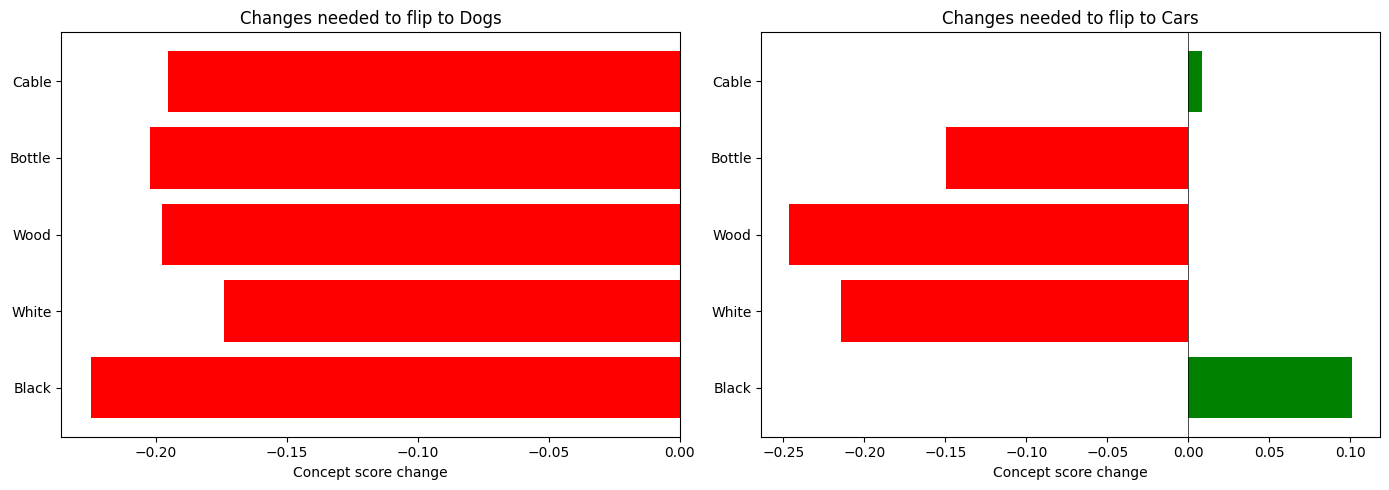

In [28]:
# Counterfactual explanation on the CBM
# Goal: find the minimal change in concept scores that would flip the prediction

def counterfactual_explanation(model, sample_concept_scores, true_class, List_concepts, List_classes):
    """
    For a given sample, find what minimal concept changes would flip the prediction
    to the correct class (or to each other class).
    """
    model.eval()

    # Get current prediction
    pred_probs = cbm_predict_for_shap(sample_concept_scores)
    pred_class = pred_probs.argmax()
    print(f"True class: {List_classes[true_class]}")
    print(f"Current prediction: {List_classes[pred_class]}")
    print(f"Current probabilities: {dict(zip(List_classes, pred_probs[0]))}")
    print(f"Current concept scores: {dict(zip(List_concepts, sample_concept_scores[0]))}")

    # For each target class, find the minimal perturbation using gradient descent
    for target_class in range(len(List_classes)):
        if target_class == pred_class:
            continue

        # Start from the original concept scores
        cf_scores = torch.tensor(sample_concept_scores, dtype=torch.float32, device=device, requires_grad=True)

        optimizer_cf = optim.Adam([cf_scores], lr=0.001)

        for step in range(1000):
            optimizer_cf.zero_grad()

            # Normalize and classify
            cf_norm = cf_scores / cf_scores.norm(dim=-1, keepdim=True)
            logits = model.classifier(cf_norm)
            probs = F.softmax(logits, dim=-1)

            # Loss: maximize target class probability + minimize distance to original
            target_loss = -torch.log(probs[0, target_class])
            distance_loss = 0.5 * torch.sum((cf_scores - torch.tensor(sample_concept_scores, device=device))**2)
            loss = target_loss + distance_loss

            loss.backward()
            optimizer_cf.step()

            # Check if prediction flipped
            if probs[0, target_class].item() > 0.5:
                break

        cf_scores_np = cf_scores.detach().cpu().numpy()
        cf_probs = cbm_predict_for_shap(cf_scores_np)
        delta = cf_scores_np[0] - sample_concept_scores[0]

        print(f"\n{'='*50}")
        print(f"Counterfactual to flip prediction to: {List_classes[target_class]}")
        print(f"Steps needed: {step+1}")
        print(f"New probabilities: {dict(zip(List_classes, cf_probs[0]))}")
        print(f"Concept changes needed:")
        for j, concept in enumerate(List_concepts):
            if abs(delta[j]) > 1e-5:
                direction = "↑" if delta[j] > 0 else "↓"
                print(f"  {concept}: {sample_concept_scores[0][j]:.4f} → {cf_scores_np[0][j]:.4f} ({direction} {abs(delta[j]):.4f})")

    # Visualization
    fig, axes = plt.subplots(1, len(List_classes)-1, figsize=(7*(len(List_classes)-1), 5))
    if len(List_classes) - 1 == 1:
        axes = [axes]

    plot_idx = 0
    for target_class in range(len(List_classes)):
        if target_class == pred_class:
            continue

        cf_scores_target = torch.tensor(sample_concept_scores, dtype=torch.float32, device=device, requires_grad=True)
        optimizer_cf = optim.Adam([cf_scores_target], lr=0.001)

        for step in range(1000):
            optimizer_cf.zero_grad()
            cf_norm = cf_scores_target / cf_scores_target.norm(dim=-1, keepdim=True)
            logits = model.classifier(cf_norm)
            probs = F.softmax(logits, dim=-1)
            target_loss = -torch.log(probs[0, target_class])
            distance_loss = 0.5 * torch.sum((cf_scores_target - torch.tensor(sample_concept_scores, device=device))**2)
            loss = target_loss + distance_loss
            loss.backward()
            optimizer_cf.step()
            if probs[0, target_class].item() > 0.5:
                break

        delta = cf_scores_target.detach().cpu().numpy()[0] - sample_concept_scores[0]

        colors = ['green' if d > 0 else 'red' for d in delta]
        axes[plot_idx].barh(List_concepts, delta, color=colors)
        axes[plot_idx].set_title(f"Changes needed to flip to {List_classes[target_class]}")
        axes[plot_idx].set_xlabel("Concept score change")
        axes[plot_idx].axvline(x=0, color='black', linewidth=0.5)
        plot_idx += 1

    plt.tight_layout()
    plt.show()

# Run counterfactual explanation
sample_data = next(iter(dataloader_embed_test))
sample_embed = sample_data['input'][0:1].to(device).float()
sample_label = sample_data['label'][0].item()

with torch.no_grad():
    sample_norm = sample_embed / sample_embed.norm(dim=-1, keepdim=True)
    sample_concept_scores = (sample_norm @ model_biaised.text_featuresconcepts.T).cpu().numpy()

counterfactual_explanation(model_biaised, sample_concept_scores, sample_label, List_concepts, List_classes)

The counterfactual explanation asks: "What would need to change in the concept scores for the model to predict a different class?"
Our sample is a Dog misclassified as Cat (probabilities: Dogs 23.4%, Cats 42.9%, Cars 33.7%).


To flip from Cats → Dogs:

The optimization needed all 1000 steps and still barely flipped the prediction (Dogs 41.5% vs Cats 30.5%). All five concept scores needed to decrease massively (by ~0.17 to 0.22), essentially pushing them all toward zero. This means there is no meaningful direction in the concept space that clearly leads to "Dogs" — the model has no coherent understanding of what makes a dog a dog with these concepts.


To flip from Cats → Cars:

This was easier (269 steps, Cars reaches exactly 50.0%). The main changes are: "Black" needs to increase (+0.10), while "White" and "Wood" need to decrease strongly (-0.21 and -0.25). "Cable" barely changes (+0.008). This reveals that the model's internal logic for Cars is essentially "high Black, low White, low Wood" — a completely arbitrary rule with no semantic meaning.


Key takeaways:

The counterfactual changes are very large relative to the original scores (changes of 0.10 to 0.25 when original scores are around 0.18). This seems contradictory — if the concepts are uninformative, why are large changes needed? The answer is that the model's decision boundaries are poorly oriented in this concept space, so the optimization has to push far to cross them.

More importantly, the required changes are semantically meaningless. "To make the model recognize a dog, decrease the Black score by 0.22 and the Wood score by 0.20" is not an actionable or interpretable explanation. Compare this to what a CBM with good concepts would produce: "To flip from Cat to Dog, increase the Snout score and decrease the Whiskers score" — that would be a genuinely useful explanation.

This final experiment confirms the central lesson of the lab: the interpretability and usefulness of XAI explanations (whether GradCAM, LIME, SHAP, or counterfactuals) fundamentally depends on the quality of the underlying representation. With naive color-based concepts, all explanation methods produce meaningless outputs. With well-chosen semantic concepts, the same methods would provide clear, actionable, and trustworthy insights into the model's reasoning.